$\newcommand{\bld}[1]{\boldsymbol{#1}}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$\newcommand{\braket}[2]{\left\langle{#1}\,\right|\left.{#2}\right\rangle}$

# III. Single particle observables

In [part II](2_state_building.ipynb) we saw how to build wavefunctions, and that we could access elements of the wavefunction by indexing  with a `Site` object. It was, however, unwieldy to calculate quantities in this manner. In this section we introduce observables, which can be used to compute quantities, given a wavefunction.

In principle one could use `kwant.Builder` to construct an arbitrary operator (matrix) defined over the central region,
but for the very common case of local *densities* (which we will define) and their *currents* we can have a more
succint way of constructing them.

In [ ]:
%run bean_system.ipy

In [ ]:
def plot_density(sys, rho):
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 12))
    kwant.plotter.map(sys, rho, ax=ax1)
    
def plot_current_density(sys, j):
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 12))
    kwant.plotter.map_current(sys, j, ax=ax1)

We briefly construct a system and one of its scattering states which will be used in the following.

In [ ]:
lat, sys = make_system()
lead = make_lead(lat)
sys.attach_lead(lead)
sys.attach_lead(lead.reversed())
tsys = sys.finalized()

args = (0.1, 1.)  # Vg, gamma
state = tkwant.wave_function(tsys, energy=0.5, args=args)(lead=0)[0]

## Densities and current densities

A very common type of quantity which one may wish to calculate is one which
is defined on every site in the finite central region of the system. In the
terminology used here we shall refer to such quantities as *densities*. Examples
include spin density, charge density and probability density. Such quantities
are in general defined by the relation:
<a class="anchor-link" href="#density-definition">¶</a>
<div style="border: 0.2em #FF9191 solid;">
$$
    \rho_i = \bld{\psi}_i^{\dagger} \mathbf{M}_i \bld{\psi}_i
$$
</div>

where $\bld{\psi}_i$ is the wavefunction projected onto site $i$. $\mathbf{M}_i$ is a hermitian matrix which 
defines the density $\rho_i$, which is a real number. Note that in principle
different sites may have different numbers of orbitals, hence the $\bld{\psi}_i$ are in principle vectors of different sizes. In practice
each lattice (`SiteFamily`) has a fixed number of orbitals per site.

In the present example there is just a single lattice in the system, which contains two orbitals per site: spin up and spin down. We can define two
obvious densities: the spin and charge densities.

In [ ]:
charge_density = tkwant.Density(tsys, lambda site, time, Vg, gamma: s_0)
spin_density = tkwant.Density(tsys, lambda site, time, Vg, gamma: s_z)

the `tkwant.Density` constructor takes two arguments, the system over which the density is defined, and a function which returns the Hermitian matrix corresponding to the density for the given site. This function must formally take
the same parameters as the Hamiltonian onsite functions.

The case where a single $\mathbf{M}$ is used for all sites is very common, hence we may also just pass this matrix as an argument:

In [ ]:
charge_density = tkwant.Density(tsys, s_0)
spin_density = tkwant.Density(tsys, s_z)

We can also provide no $\mathbf{M}$, in which case the identity matrix is assumed

In [ ]:
charge_density = tkwant.Density(tsys)

We can then use these objects to calculate the densities for our state and plot
them

In [ ]:
Q = charge_density(state)
plot_density(tsys, Q)

In [ ]:
S = spin_density(state)
plot_density(tsys, S)

We don't need to explicitly provide `args`, as the objects returned by `tkwant.wave_function` and `tkwant.wave_packet` are not just simple arrays, but are objects that remember the `args` that they were created with.
We can still use the density objects with simple arrays (such as those returned by `kwant.wave_function`), however,
by explicitly passing arguments:

In [ ]:
# note that we have to explicitly pass the time parameter,
# as it is not treated specially by Kwant
kwant_args = (0,) + args
kwant_state = kwant.wave_function(tsys, energy=0.5, args=kwant_args)
Q = charge_density(kwant_state, kwant_args)

We can also access individual elements of these densities by indexing them in the same way
as we could index states in the [previous tutorial](2_state_ building.ipynb).

In [ ]:
print Q[lat(2, 4)]
print S[(lat(i, j) for i in xrange(2) for j in xrange(3, 5))]

Next we shall move on to calculating current densities. Given a density $\rho_i$ defined
in the above manner, we can associate a current density $J_{ij}$ flowing *from* site $j$ *to* site $i$
via a continuity equation:
$$
    \partial_t \rho_i(t) - \sum_{j\in N(i)} J_{ij} = 0
$$
where $N(i)$ are the neighbours of site $i$.

We know that $\rho_i = \bld{\psi}_i^{\dagger} \mathbf{M}_i \bld{\psi}_i$ and that $\bld{\psi}_i$ satisfies a Schrödinger equation
$$
i\partial_t \bld{\psi}_i(t) = \sum_{j \in (N(i) \cup \{i\})} \mathbf{H}_{ij}(t) \bld{\psi}_j(t)
$$
and its hermitian conjugate
$$
-i\partial_t \bld{\psi}_i^\dagger(t) = \sum_{j \in (N(i) \cup \{i\})} \bld{\psi}_j^\dagger(t) \mathbf{H}_{ij}^\dagger(t) 
$$
where $\mathbf{H}_{ij}(t)$ are the Hamiltonian matrix elements between orbitals on site $i$ and $j$. Hence we can re-write the continuity equation as
$$
\begin{split}
\sum_{j \in N(i)} \left[ i \left(
    \bld{\psi}_j^\dagger(t) \mathbf{H}^\dagger_{ij}(t) \mathbf{M}_i \bld{\psi}_i(t)
    - \bld{\psi}_i^\dagger(t) \mathbf{M}_i \mathbf{H}_{ij}(t) \bld{\psi}_j(t)
    \right) - J_{ij}\right]\\
    +\, 
    \bld{\psi}_i^\dagger(t) \mathbf{H}^\dagger_{ii}(t) \mathbf{M}_i \bld{\psi}_i(t)
    - \bld{\psi}_i^\dagger(t) \mathbf{M}_i \mathbf{H}_{ii}(t) \bld{\psi}_i(t)
     = 0
\end{split}
$$
which we simplify, using the fact that $i(z - z^*) = 2\Im(z^*)$ and the hermicity of  the matrices $\mathbf{H}_{ii}(t)$ and $\mathbf{M}_i$, to
$$
\sum_{j \in N(i)} \left[ 2\Im\left(
    \bld{\psi}_i^\dagger(t) \mathbf{M}_i \mathbf{H}_{ij}(t) \bld{\psi}_j(t)
    \right) - J_{ij}\right] + 
    \bld{\psi}_i^\dagger(t)[\mathbf{H}_{ii}(t), \mathbf{M}_i] \bld{\psi}_i(t)
    = 0
$$
where $\Im$ denotes the imaginary part and $[\cdot, \cdot]$ is the commutator. We notice
that if $[\mathbf{H}_{ii}(t), \mathbf{M}_i] = 0$ then
<a class="anchor-link" href="#current-definition">¶</a>
<div style="border: 0.2em #FF9191 solid;">
$$ 
J_{ij} = 2\Im\left(\bld{\psi}_i^\dagger(t) \mathbf{M}_i \mathbf{H}_{ij}(t)\bld{\psi}_j(t)\right)
$$
</div>
We use this relation to define our current density.

<div class="alert alert-warning" data-toggle="collapse" data-target="#caution3">
<p>**Note of caution** <i class="pull-right fa fa-chevron-down"></i></p>
<div id="caution3" class="collapse">
While it is true that one can always define a quantity as we have done above and call it a
"current density", one must always be prudent, as if $[\mathbf{H}_{ii}(t), \mathbf{M}_i] \ne 0$ then
the the density is not a conserved quantity. A common example is BCS superconductivity, where
one has a Bogoliubov-de Gennes Hamiltonian. The onsite part of the BdG Hamiltonian can be written
$$
    \mathbf{H}_{ii} = (H_0 - \mu)\bld{\tau}_z + \Delta\bld{\tau}_x
$$
(if $\Delta, H_0 \in \mathbb{R}$) where $\bld{\tau}_a$ are Pauli matrices. If one defines the *charge density* via $\mathbf{M}_i = -\bld{\tau}_z$ (i.e. hole part minus electron part)
then clearly $[\mathbf{H}_{ii}, \mathbf{M}_i] \ne 0$ because of the $\bld{\tau}_x$ superconducting term. Hence in BCS theory the charge is not a conserved quantity and a well-defined, conserved electric current is lost in the superconductor.
</div>
</div>

We can now define current densities which are derived from the corresponding densities for our
example

In [ ]:
charge_current = tkwant.CurrentDensity(charge_density)
spin_current = tkwant.CurrentDensity(spin_density)

Or we can equivalently provide the same arguments as to the `tkwant.Density` constructor

In [ ]:
charge_current = tkwant.CurrentDensity(tsys, s_0)
spin_current = tkwant.CurrentDensity(tsys, s_z)

and apply the observable to the states

In [ ]:
J = charge_current(state)
plot_current_density(tsys, J)

In [ ]:
JS = spin_current(state)
plot_current_density(tsys, JS)

We can access the currents densities between given hoppings by indexing the `tkwant.CurrentDensity` object with a pair of sites.

In [ ]:
print J[lat(3, 5), lat(4, 5)]

### Densities and current densities on subsets of sites

The central part of tkwant systems can be rather large,  typically of the order of $10^5$ or $10^6$ sites. Sometimes (quite often in fact!) one is not interested by the value of a density / current density *everywhere* in the system, but only on/between certain sites.

When specifying densities tkwant allows you to specify this by passing a `where` argument to `tkwant.Density`. You may specify `where` in one of two ways: the first is to provide a function which takes a site and returns true if the density should be calculated for this site, the second is to simply provide a list of sites.

In [ ]:
def in_disk(site):
    x, y = site.pos
    xc, yc = (0, 8)
    return (x - xc)**2 + (y - yc)**2 < 3**2

site_list = [lat(0, 4), lat(5, 6)]

charge_density_in_disk = tkwant.Density(tsys, s_0, where=in_disk)

charge_density_2_sites = tkwant.Density(tsys, s_0, where=site_list)

The images below show the sites for which the density will be calculated in red.

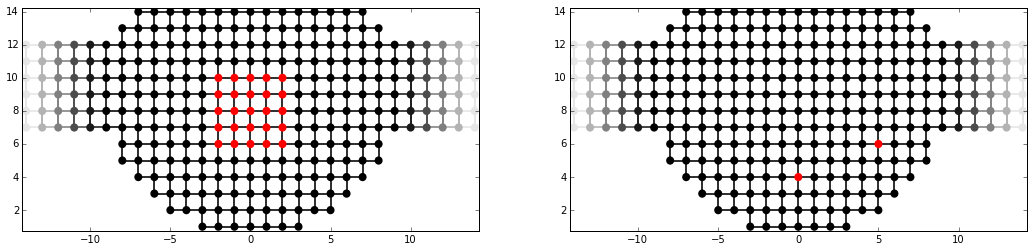

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))


def in_site_list(site):
    return site in site_list

def site_color(f):
    return (lambda s: 'r' if f(s) else 'k')

kwant.plot(sys, ax=ax1, num_lead_cells=5, lead_color='k',
           site_color=site_color(in_disk))
kwant.plot(sys, ax=ax2, num_lead_cells=5, lead_color='k',
           site_color=site_color(in_site_list))

Current densities may be specified in an analogous way. This time the `where` function takes two sites and returns true if the current should be calculated for the hopping between the two sites. A list of hoppings (pairs of sites) may equivalently be provided, as may a `kwant.HoppingKind` object.

In [ ]:
def cuts_circle(site_i, site_j):
    return in_disk(site_i) and not in_disk(site_j)

def in_hop_list(site_i, site_j):
    return (site_i, site_j) in hop_list

hop_list = [(lat(0, 8), lat(1, 8)), ((lat(3, 6), lat(3, 7)))]

current_from_disk = tkwant.Current(tsys, s_0, where=cuts_circle)
current_arbitrary = tkwant.Current(tsys, s_0, where=hop_list)
up_currents = tkwant.Current(tsys, s_0, where=kwant.HoppingKind(lat, (0, 1)))

The images below show the hoppings for which the current density will be calculated in red.

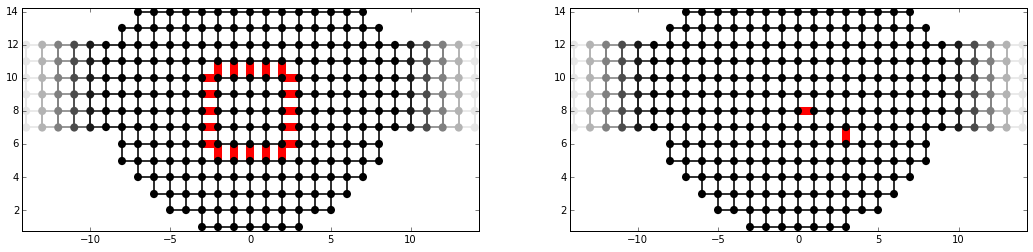

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))

def hop_color(f):
    return (lambda si, sj:
        'r' if f(sj, si) or f(si, sj)  else 'k')

def hop_lw(f):
    return (lambda si, sj:
        0.5 if f(sj, si) or f(si, sj)  else 0.1)
    
kwant.plot(sys, ax=ax1, num_lead_cells=5, lead_color='k',
           hop_color=hop_color(cuts_circle), hop_lw=hop_lw(cuts_circle))
kwant.plot(sys, ax=ax2, num_lead_cells=5, lead_color='k',
           hop_color=hop_color(in_hop_list), hop_lw=hop_lw(in_hop_list))

<div class="alert alert-warning" data-toggle="collapse" data-target="#note4">
<p>**Note of caution** <i class="pull-right fa fa-chevron-down"></i></p>
<div id="note4">
The `where` functions for `tkwant.CurrentDensity` should be "asymmetric" in the sense that if they
evaluate to `True` for a hopping $(i, j)$ they it should return `False` for hopping $(j, i)$.
If this is not the case then the direction of "positive" current is badly defined.
</div>

<div class="alert alert-info" data-toggle="collapse" data-target="#note2">
<p>**Implementation Note** <i class="pull-right fa fa-chevron-down"></i></p>
<div id="note2" class="collapse">
We should build a sparse projection matrix in order to get the wavefunction on the required
sites.
</div>

### Summing over several sites/hoppings

`tkwant.Density` and `tkwant.CurrentDensity` can take another parameter, `sum`, which controls whether we do a sum over the sites / hoppings.
In this case the quantity should more properly be called a "charge" or a "current" rather than "density" and "current density".

In [9]:
charge_in_disk = tkwant.Density(tsys, s_0, where=in_disk, sum=True)

def across_y_axis(site_i, site_j):
    return site_j.pos[0] <= 0 and site_i.pos[0] > 0  # current from left to right

current_across_centre = tkwant.CurrentDensity(tsys, s_0, where=across_y_axis,
                                              sum=True)

Using this we can check that the transmission in the system is equal to the sum of the currents for the different scattering states

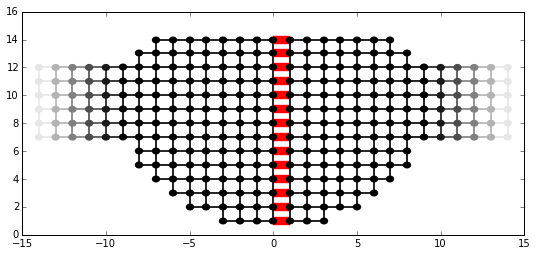

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))

def hop_color(f):
    return (lambda si, sj: 'r' if (f(sj, si) or f(si, sj))  else 'k')

def hop_lw(f):
    return (lambda si, sj: 0.5 if (f(sj, si) or f(si, sj))  else 0.1)
    
kwant.plot(sys, ax=ax1, num_lead_cells=5, lead_color='k',
           hop_color=hop_color(across_y_axis), hop_lw=hop_lw(across_y_axis))

In [ ]:
args = (Vg=1., gamma=1.)
T = kwant.smatrix(tsys, energy=1., args=(0,)+args).transmission(1, 0)  # left to right

# states coming from left lead (0)
scattering_states = tkwant.wave_function(tsys, energy=1., args=args)(0)

I = sum(current_accross_centre(state) for state in states)

print I, T